# Boundless Colab

Welcome to the Boundless model Colab! This notebook will take you through the steps of running the model on images and visualize the results.

## Overview

Boundless is a model for image extrapolation. This model takes an image, internally masks a portion of it ([1/2](https://tfhub.dev/google/boundless/half/1), [1/4](https://tfhub.dev/google/boundless/quarter/1), [3/4](https://tfhub.dev/google/boundless/three_quarter/1)) and completes the masked part. For more details refer to [Boundless: Generative Adversarial Networks for Image Extension](https://arxiv.org/pdf/1908.07007.pdf) or the model documentation on TensorFlow Hub.

- no adaptivity
- recover the image using the pre-train model

## Imports and Setup

Lets start with the base imports.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from io import BytesIO
from PIL import Image as PilImage
import numpy as np
from matplotlib import pyplot as plt
from six.moves.urllib.request import urlopen

2023-03-01 18:33:21.420798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Reading image for input

Lets create a util method to help load the image and format it for the model (257x257x3). This method will also crop the image to a square to avoid distortion and you can use with local images or from the internet.

In [2]:
def read_image(filename):
    fd = None
    if(filename.startswith('http')):
      fd = urlopen(filename)
    else:
      fd = tf.io.gfile.GFile(filename, 'rb')

    pil_image = PilImage.open(fd)
    width, height = pil_image.size
    # crop to make the image square
    pil_image = pil_image.crop((0, 0, height, height))
    pil_image = pil_image.resize((257,257),PilImage.ANTIALIAS)
    image_unscaled = np.array(pil_image)
    image_np = np.expand_dims(
        image_unscaled.astype(np.float32) / 255., axis=0)
    return image_np

## Visualization method

We will also create a visuzalization method to show the original image side by side with the masked version and the "filled" version, both generated by the model.

In [3]:
def visualize_output_comparison(img_original, img_masked, img_filled):
  plt.figure(figsize=(24,12))
  plt.subplot(131)
  plt.imshow((np.squeeze(img_original)))
  plt.title("Original", fontsize=24)
  plt.axis('off')
  plt.subplot(132)
  plt.imshow((np.squeeze(img_masked)))
  plt.title("Masked", fontsize=24)
  plt.axis('off')
  plt.subplot(133)
  plt.imshow((np.squeeze(img_filled)))
  plt.title("Generated", fontsize=24)
  plt.axis('off')
  plt.show()

## Loading an Image

We will load a sample image but fell free to upload your own image to the colab and try with it. Remember that the model have some limitations regarding human images.

In [11]:
wikimedia = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Nusfjord_road%2C_2010_09.jpg/800px-Nusfjord_road%2C_2010_09.jpg"
# wikimedia = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Beech_forest_M%C3%A1tra_in_winter.jpg/640px-Beech_forest_M%C3%A1tra_in_winter.jpg"
# wikimedia = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Marmolada_Sunset.jpg/640px-Marmolada_Sunset.jpg"
# wikimedia = "https://upload.wikimedia.org/wikipedia/commons/thumb/9/9d/Aegina_sunset.jpg/640px-Aegina_sunset.jpg"

input_img = read_image(wikimedia)

/var/folders/_j/z7zdrth14_s3bcxmp4glxrw40000gp/T/ipykernel_10498/3295904410.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_image = pil_image.resize((257,257),PilImage.ANTIALIAS)


## Selecting a model from TensorFlow Hub

On TensorFlow Hub we have 3 versions of the Boundless model: Half, Quarter and Three Quarters.
In the following cell you can chose any of them and try on your image. If you want to try with another one, just chose it and execute the following cells.

In [12]:
#@title Model Selection { display-mode: "form" }
model_name = 'Boundless Quarter' # @param ['Boundless Half', 'Boundless Quarter', 'Boundless Three Quarters']
model_handle_map = {
    'Boundless Half' : 'https://tfhub.dev/google/boundless/half/1',
    'Boundless Quarter' : 'https://tfhub.dev/google/boundless/quarter/1', 
    'Boundless Three Quarters' : 'https://tfhub.dev/google/boundless/three_quarter/1'
}

model_handle = model_handle_map[model_name]


Now that we've chosen the model we want, lets load it from TensorFlow Hub.

**Note**: You can point your browser to the model handle to read the model's documentation.

In [13]:
print("Loading model {} ({})".format(model_name, model_handle))
model = hub.load(model_handle)

Loading model Boundless Quarter (https://tfhub.dev/google/boundless/quarter/1)


## Doing Inference

The boundless model have two outputs:

*   The input image with a mask applied
*   The masked image with the extrapolation to complete it

we can use these two images to show a comparisson visualization.

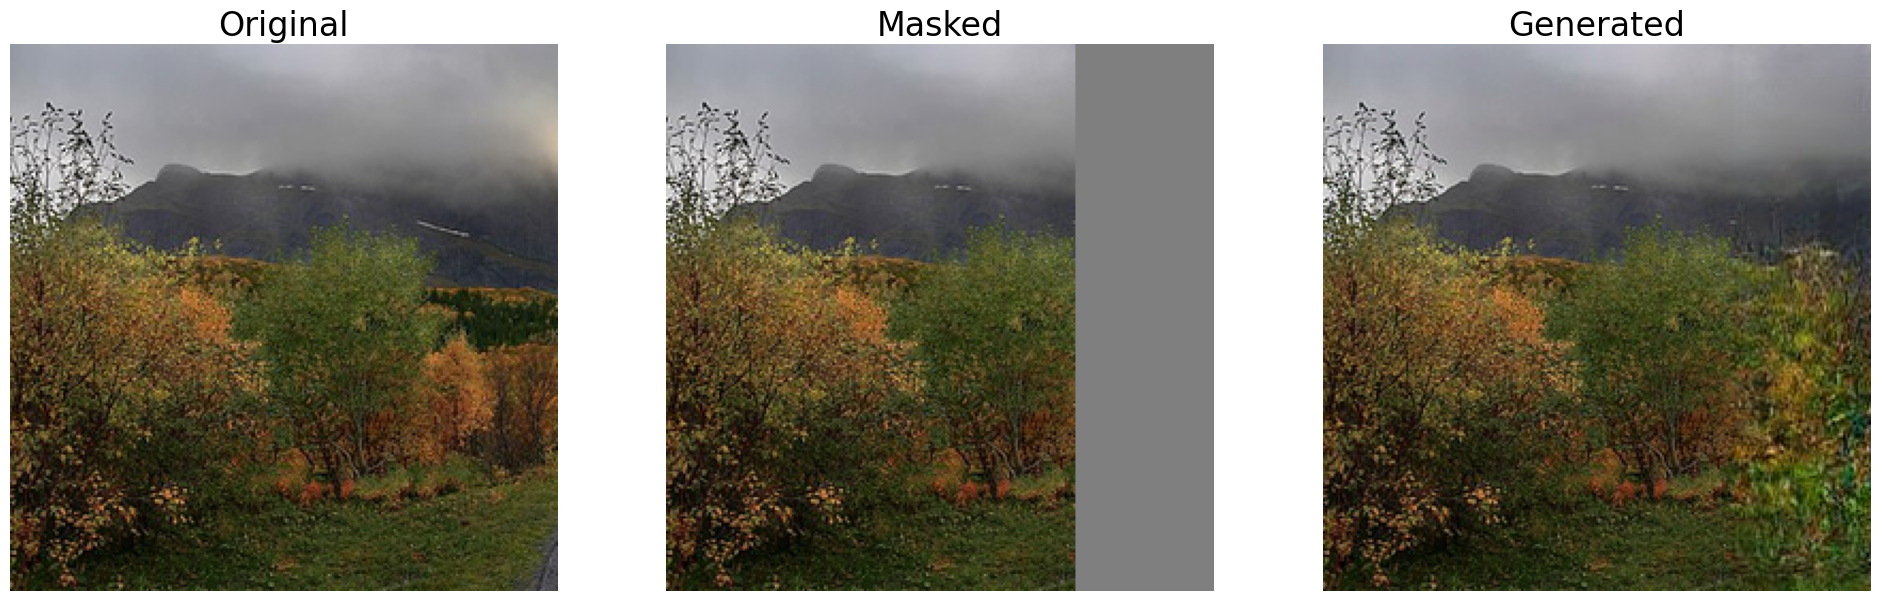

In [14]:


result = model.signatures['default'](tf.constant(input_img))
generated_image =  result['default']
masked_image = result['masked_image']

visualize_output_comparison(input_img, masked_image, generated_image)

# Mechanized Inference

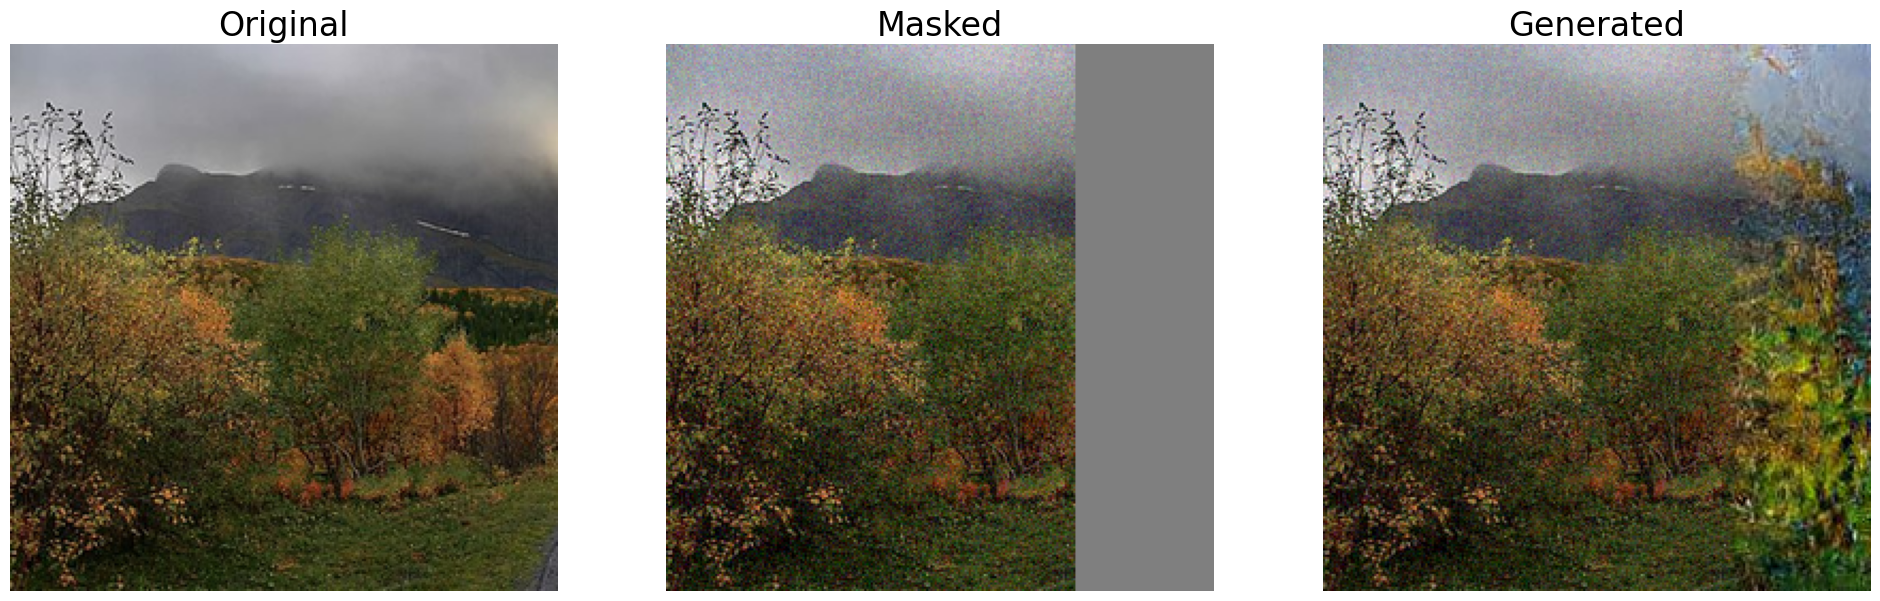

In [18]:
input_image = tf.constant(input_img)
noise = tf.random.normal(tf.shape(input_image), mean=0.0, stddev=0.05, dtype = tf.dtypes.float32, seed=None, name=None)
noised_image = input_image + noise

result = model.signatures['default'](noised_image)
generated_image =  result['default']
masked_image = result['masked_image']

visualize_output_comparison(input_image, masked_image, generated_image)